In [12]:
from music21 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from music21.repeat import Expander
import scipy
from scipy.ndimage.filters import gaussian_filter1d
from dtw import *

In [124]:
def calculate_dtw_distance(sequence1, sequence2):
    alignment = dtw(sequence1, sequence2, keep_internals=True)
    return alignment.distance

def compute_kernel_checkerboard_gaussian(L, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1/2) / (L * var)
    axis = np.arange(-L, L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

def calculate_ssm(sequence):
    length = len(sequence[0])
    feature_size = len(sequence)
    ssm = np.zeros((feature_size, length, length))

    for k in range(feature_size):
        i = 0
        for element_i in sequence[k]:
            j = 0
            for element_j in sequence[k]:
                embedding1 = np.array(element_i)
                embedding2 = np.array(element_j)
                
                if embedding1.shape[0] == 0 and embedding2.shape[0] == 0:
                    ssm[k][i][j] = 0
                    j += 1
                    continue
                
                if embedding1.shape[0] == 0:
                    ssm[k][i][j] = np.sum(embedding2)
                elif embedding2.shape[0] == 0:
                    ssm[k][i][j] = np.sum(embedding1)
                else:
                    ssm[k][i][j] = (calculate_dtw_distance(embedding1, embedding2))
                
                j += 1
            i += 1

    return ssm


def novelty_from_ssm(SSM, L):
    kernel = compute_kernel_checkerboard_gaussian(L=L)
    N = SSM.shape[0]
    M = 2*L + 1
    novelty = np.zeros(N)
    S_padded = np.pad(SSM, L, mode='constant')
    for n in range(N):
        novelty[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)

    return novelty

def calculate_and_plot_novelty(self_sim_mat_aud, L_kernel, feature_name, file_path):

    novelty = novelty_from_ssm(self_sim_mat_aud, L_kernel)  
    
    data_filtered = gaussian_filter1d(novelty, sigma=1)
    indices = scipy.signal.argrelmax(data_filtered)[0]
    
    print(feature_name + ', '.join(str(index) for index in indices))
    x = np.arange(len(novelty))

    plt.figure()
    plt.plot(x, novelty)
    plt.title('Novelty Function of ' + feature_name + ' for ' + file_path, fontsize=8)
    plt.xlabel('Measures', fontsize=8)
    plt.ylabel('Novelty value', fontsize=8)

    for index in indices:
        plt.axvline(x=index, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("output/novelty_" + file_path.split('/')[-1].split('.')[0] + "_" + feature_name + ".png")

    plt.show()
    plt.clf()
    
    return indices

def standardize_features(feature):
    flattened_array = [element for sublist in feature for element in sublist]
    # mean_value = np.mean(flattened_array)
    # std_value = np.std(flattened_array)
    min_value = np.min(flattened_array)
    max_value = np.max(flattened_array)
    standardized_feature = [[(element - min_value) / (max_value - min_value) for element in sublist] for sublist in feature]
    # standardized_feature = [[(element - mean_value) / std_value for element in sublist] for sublist in feature]
    return standardized_feature

def get_features(midi, is_score):
    feat_duration = []
    feat_pitch = []
    for measure in midi.getElementsByClass(stream.Measure):
        duration_vec = []
        pitch_vec = []
        for event in measure.recurse():
            if isinstance(event, note.Note) :
                duration_vec.append([float(event.duration.quarterLength)])
                pitch_vec.append(event.pitch.ps)
            elif isinstance(event, chord.Chord):
                duration_vec.append([float(event.duration.quarterLength)])
                pitch_vec.append(event.root().ps)
            else:
                continue
        feat_duration.append(duration_vec)
        feat_pitch.append(pitch_vec)
        
    standardized_feat_duration = standardize_features(feat_duration)
    standardized_feat_pitch = standardize_features(feat_pitch)
    
    if not is_score:
        feat_velocity = []
        for measure in midi.getElementsByClass(stream.Measure):
            velocity_vec = []
            for event in measure.recurse():
                if isinstance(event, note.Note) :
                    velocity_vec.append(event.volume.velocity)
                elif isinstance(event, chord.Chord):
                    velocity_vec.append(event.volume.velocity)
                else:
                    continue
            feat_velocity.append(velocity_vec)
        standardized_feat_velocity = standardize_features(feat_velocity)
        return [standardized_feat_duration, standardized_feat_velocity, standardized_feat_pitch]
    return [standardized_feat_duration, standardized_feat_pitch]

def plot_ssm_and_novelty(ssm, feature_name, file_path):
    measure_cnt = ssm.shape[0]
    plt.set_cmap('viridis')
    plt.imshow(ssm, cmap='viridis', interpolation='nearest', extent=[0, measure_cnt, measure_cnt,0])
    plt.xticks(range(0, measure_cnt, 10), fontsize=8)
    plt.yticks(range(0, measure_cnt, 10), fontsize=8)
    plt.xlabel('Measures', fontsize=8)
    plt.ylabel('Measures', fontsize=8)
    plt.title('SSM of ' + feature_name + ' for ' + file_path, fontsize=8)
    plt.tight_layout()
    plt.savefig("output/ssm_" + file_path.split('/')[-1].split('.')[0] + "_" + feature_name + ".png")
    # plt.show()
    plt.clf()
    
    return calculate_and_plot_novelty(ssm, measure_cnt // 10, feature_name, file_path)   

def get_phrase_boundary(file_path, is_score):
    midi_file = converter.parse("asap-dataset-master/" + file_path)
    midi_file.makeMeasures(inPlace=True)
    midi_file = midi_file.expandRepeats()
    features = get_features(midi_file, is_score)
    ssm = calculate_ssm(features)
  
    feature_names = ['Duration', 'Velocity', 'Pitch'] if not is_score else ['Duration', 'Pitch']
    for i in range(ssm.shape[0]):
        plot_ssm_and_novelty(ssm[i], feature_names[i], file_path)
        
    ssm_mean = np.mean(ssm, axis=0)
    return plot_ssm_and_novelty(ssm_mean, 'mean of all features', file_path)
        
get_phrase_boundary('Mozart/Piano_Sonatas/11-3/Stahievitch02.mid', is_score=False)
get_phrase_boundary('Mozart/Piano_Sonatas/11-3/xml_score.musicxml', is_score=True)

array([ 10,  26,  42,  61,  75,  91, 102, 112])

In [135]:
def plot_phrase_cnt_dist(phrases, is_score):
    phrases_cnt = [len(phrase) for phrase in phrases]
    
    min_phrases_cnt = min(phrases_cnt)
    max_phrases_cnt = max(phrases_cnt)
    bins = np.arange(min_phrases_cnt, max_phrases_cnt + 2) - 0.5
    
    plt.hist(phrases_cnt, bins=bins)
    plt.xlabel('Number of Phrases')
    plt.ylabel('Number of Pieces')
    plt.xticks(range(min_phrases_cnt, max_phrases_cnt + 1))
    if is_score:
        plt.title('Distribution of Phrase Number of Scores in Mozart folder')
        plt.savefig("output/histogram_phrase_count_score.png")
    else:
        plt.title('Distribution of Phrase Number of Performances in Mozart folder')
        plt.savefig("output/histogram_phrase_count.png")
    plt.show()


In [126]:
# apply get_phrase_boundary function to all midi files (except midi_score.midi) in the asap-dataset-master folder, set is_score to False
import os
phrases = []
file_name = []
for root, dirs, files in os.walk("asap-dataset-master/Mozart"):
    for file in files:
        if file.endswith(".mid") and not file.endswith("midi_score.mid"):
            print(os.path.join(root, file)[len("asap-dataset-master/"):])
            filename = os.path.join(root, file)[len("asap-dataset-master/"):]
            indices = get_phrase_boundary(filename, is_score=False)
            phrases.append(indices)
            file_name.append(filename)

Mozart/Fantasie_475/Huangci05M.mid
Mozart/Piano_Sonatas/12-3/WuuE04M.mid
Mozart/Piano_Sonatas/12-3/MunA05M.mid
Mozart/Piano_Sonatas/12-3/BLINOV01.mid
Mozart/Piano_Sonatas/12-2/MunA04.mid
Mozart/Piano_Sonatas/12-2/WuuE03.mid
Mozart/Piano_Sonatas/8-1/LEE_J03.mid
Mozart/Piano_Sonatas/8-1/Rozanski02.mid
Mozart/Piano_Sonatas/8-1/Lo01.mid
Mozart/Piano_Sonatas/8-1/Bogdanovitch01.mid
Mozart/Piano_Sonatas/8-1/Jia01.mid
Mozart/Piano_Sonatas/11-3/Stahievitch02.mid
Mozart/Piano_Sonatas/12-1/TET01.mid
Mozart/Piano_Sonatas/12-1/MunA03M.mid
Mozart/Piano_Sonatas/12-1/WuuE02M.mid
Mozart/Piano_Sonatas/12-1/ADIG01.mid


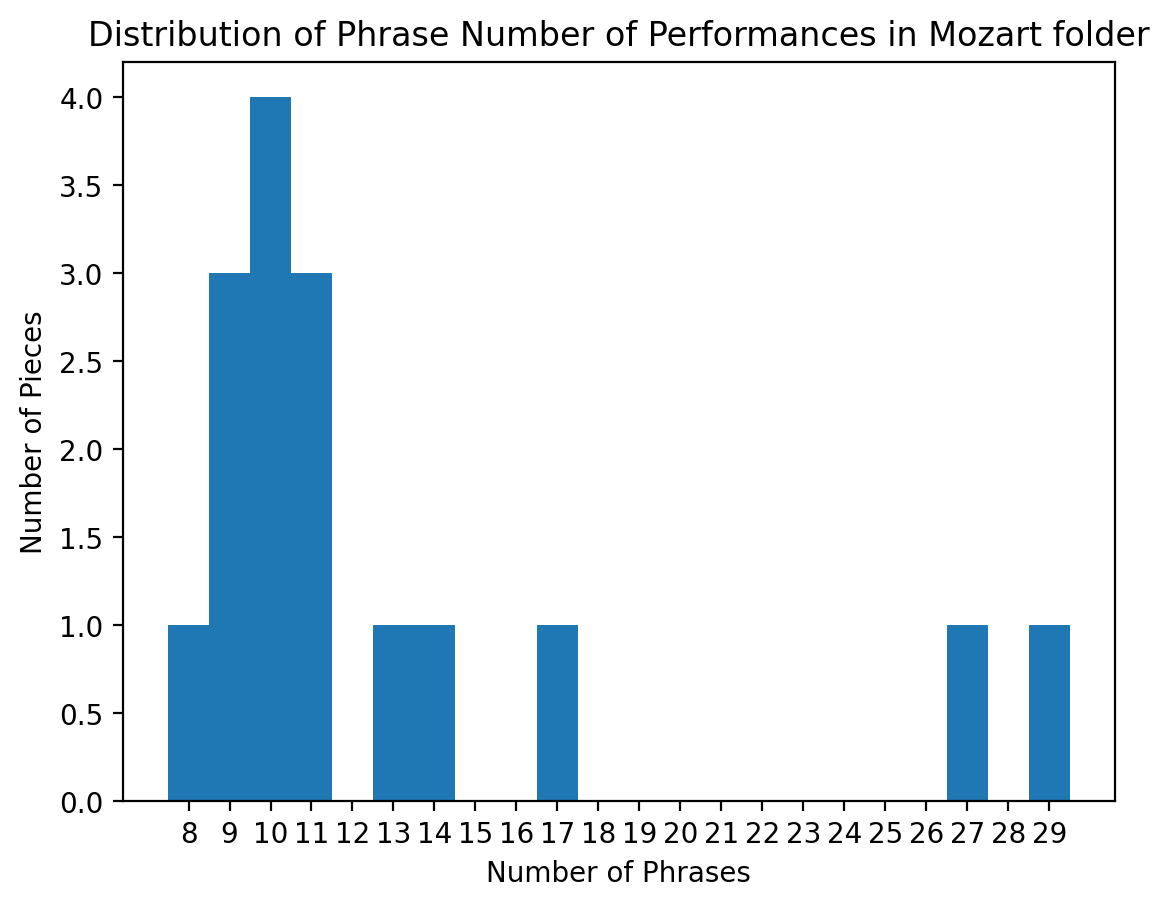

In [136]:
plot_phrase_cnt_dist(phrases, is_score=False)

In [134]:
# apply get_phrase_boundary function to all xml files in the asap-dataset-master folder, set is_score to True
phrases_score = []
file_name_score = []
for root, dirs, files in os.walk("asap-dataset-master/Mozart"):
    for file in files:
        if file.endswith(".musicxml"):
            print(os.path.join(root, file)[len("asap-dataset-master/"):])
            filename = os.path.join(root, file)[len("asap-dataset-master/"):]
            indices = get_phrase_boundary(filename, is_score=True)
            phrases_score.append(indices)
            file_name_score.append(filename)

Mozart/Fantasie_475/xml_score.musicxml
Mozart/Piano_Sonatas/12-3/xml_score.musicxml
Mozart/Piano_Sonatas/12-2/xml_score.musicxml
Mozart/Piano_Sonatas/8-1/xml_score.musicxml
Mozart/Piano_Sonatas/11-3/xml_score.musicxml
Mozart/Piano_Sonatas/12-1/xml_score.musicxml


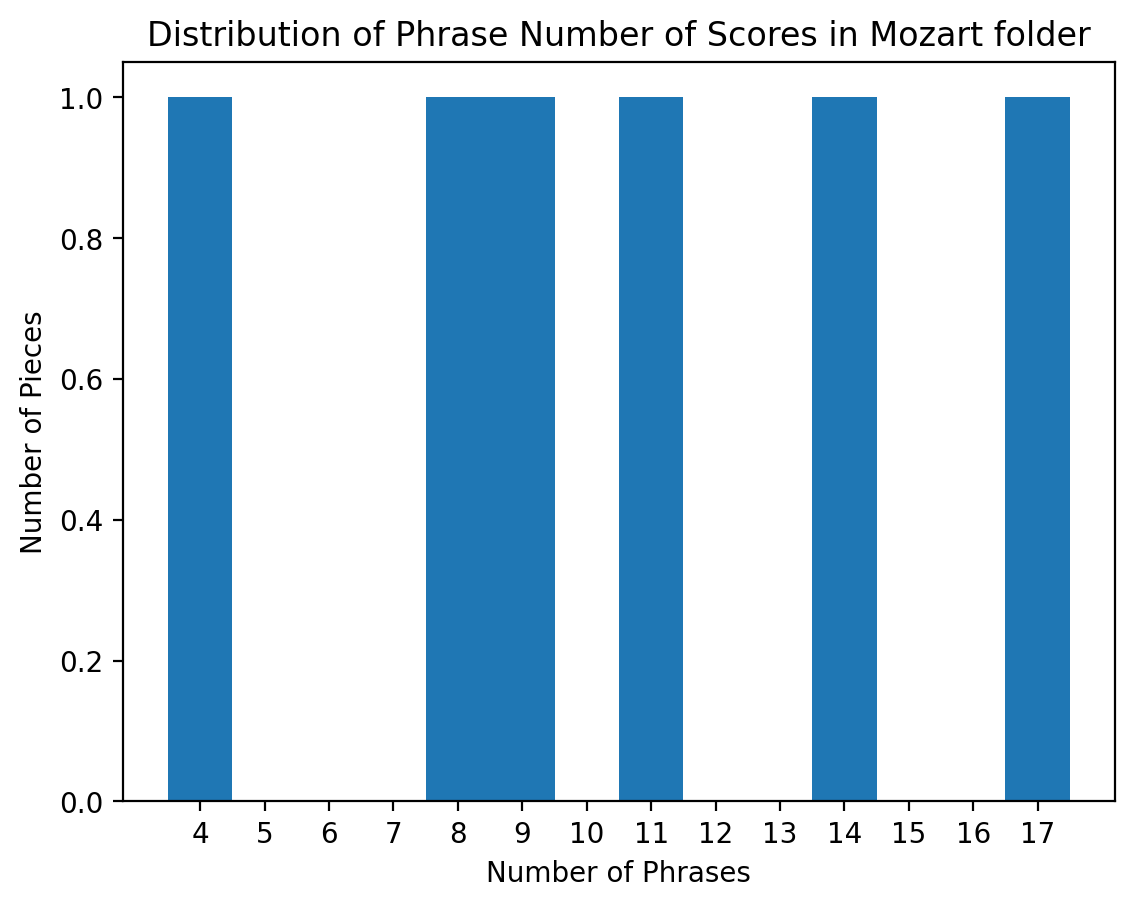

In [137]:
plot_phrase_cnt_dist(phrases_score, is_score=True)


In [140]:

for i in range(len(file_name)):
    print(file_name[i], len(phrases[i]))

Mozart/Fantasie_475/Huangci05M.mid 17
Mozart/Piano_Sonatas/12-3/WuuE04M.mid 14
Mozart/Piano_Sonatas/12-3/MunA05M.mid 11
Mozart/Piano_Sonatas/12-3/BLINOV01.mid 13
Mozart/Piano_Sonatas/12-2/MunA04.mid 27
Mozart/Piano_Sonatas/12-2/WuuE03.mid 29
Mozart/Piano_Sonatas/8-1/LEE_J03.mid 10
Mozart/Piano_Sonatas/8-1/Rozanski02.mid 11
Mozart/Piano_Sonatas/8-1/Lo01.mid 9
Mozart/Piano_Sonatas/8-1/Bogdanovitch01.mid 10
Mozart/Piano_Sonatas/8-1/Jia01.mid 8
Mozart/Piano_Sonatas/11-3/Stahievitch02.mid 9
Mozart/Piano_Sonatas/12-1/TET01.mid 9
Mozart/Piano_Sonatas/12-1/MunA03M.mid 10
Mozart/Piano_Sonatas/12-1/WuuE02M.mid 11
Mozart/Piano_Sonatas/12-1/ADIG01.mid 10


In [141]:
for i in range(len(file_name_score)):
    print(file_name_score[i], len(phrases_score[i]))

Mozart/Fantasie_475/xml_score.musicxml 11
Mozart/Piano_Sonatas/12-3/xml_score.musicxml 17
Mozart/Piano_Sonatas/12-2/xml_score.musicxml 4
Mozart/Piano_Sonatas/8-1/xml_score.musicxml 9
Mozart/Piano_Sonatas/11-3/xml_score.musicxml 8
Mozart/Piano_Sonatas/12-1/xml_score.musicxml 14
